In [1]:
import os
import glob
import time
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import keras
import tensorflow as tf
from keras import optimizers
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import to_categorical
from keras.layers import Dense, Input
from keras.models import Model, load_model
from keras.applications import MobileNetV2
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

In [2]:
dataPath = "C:\\Users\\KOTC\\Desktop\\0919\\Test0919.npz"
data = np.load(dataPath)

X_data = data['X_data']
y_data = data['y_data']
i_data = data['i_data']

data.close()

print("X_data: ", X_data.shape)
print("y_data: ", y_data.shape)
print("i_data: ", i_data.shape)

X_data:  (40500, 16, 16, 3)
y_data:  (40500,)
i_data:  (40500,)


In [3]:
# Data split

# Set random seed for reproductivity
seed = 42

# Train - Test split
X_train, X_test, y_train, y_test, i_train, i_test = train_test_split(X_data, y_data, i_data, test_size= 0.2, shuffle= True, random_state= seed, stratify= y_data)

# Train - Validation split
X_train, X_val, y_train, y_val, i_train, i_val = train_test_split(X_train, y_train, i_train, test_size= 0.2, shuffle= True, random_state= seed, stratify= y_train)

print(X_train.shape, X_test.shape, X_val.shape)
print(y_train.shape, y_test.shape, y_val.shape)
print(i_train.shape, i_test.shape, i_val.shape)

print(np.unique(y_train, return_counts= True))
print(np.unique(y_test, return_counts= True))
print(np.unique(y_val, return_counts= True))

(25920, 16, 16, 3) (8100, 16, 16, 3) (6480, 16, 16, 3)
(25920,) (8100,) (6480,)
(25920,) (8100,) (6480,)
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26]), array([960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960,
       960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960,
       960], dtype=int64))
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26]), array([300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300,
       300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300,
       300], dtype=int64))
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26]), array([240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240,
       240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240,
       240], dtype=int64))


In [4]:
# One - hot encoding
trainTargets = to_categorical(y_train)
testTargets = to_categorical(y_test)
valTargets = to_categorical(y_val)

print("Train targets: ", trainTargets.shape)
print("Test targets: ", testTargets.shape)
print("Validation targets: ", valTargets.shape)

Train targets:  (25920, 27)
Test targets:  (8100, 27)
Validation targets:  (6480, 27)


In [8]:
with tf.device("/device:GPU:0"):
    inputTensor = Input(shape= (16, 16, 3))

    model = MobileNetV2(input_tensor= inputTensor,
                        include_top= False,
                        weights= None,
                        pooling= 'max')

    x = model.output
    x = Dense(27, activation= 'softmax', kernel_initializer= 'he_normal')(x)

    model = Model(model.input, x)

    optim = optimizers.SGD(learning_rate= 0.01,
                           decay= 1e-3,
                           momentum= 0.9,
                           nesterov= True)

    model.compile(optimizer= optim,
                  loss= 'categorical_crossentropy',
                  metrics= ['accuracy'])

    print("Training ===================================================")
    startTime = time.time()

    history = model.fit(X_train, trainTargets,
                        batch_size= 16,
                        epochs= 100,
                        verbose= 1,
                        validation_data= (X_val, valTargets))

    endTime = time.time()

    print(f"Training time: {np.round(endTime - startTime), 3} sec")

    model.save("C:\\Users\\KOTC\\Desktop\\0919\\Test0919_weights_Epoch_100.h5")

    print("Score for train dataset")
    score = model.evaluate(X_train, trainTargets, verbose= 1)
    print(f"Score: \n{model.metrics_names[0]} : {score[0]}\n{model.metrics_names[1]} : {score[1] * 100}%")

Training ===================================================
Epoch 1/100
1620/1620 [==============================] - 37s 21ms/step - loss: 1.3474 - accuracy: 0.5887 - val_loss: 3.5130 - val_accuracy: 0.0370
Epoch 2/100
1620/1620 [==============================] - 32s 20ms/step - loss: 0.3433 - accuracy: 0.8879 - val_loss: 3.2252 - val_accuracy: 0.0370
Epoch 3/100
1620/1620 [==============================] - 33s 20ms/step - loss: 0.1666 - accuracy: 0.9517 - val_loss: 2.0579 - val_accuracy: 0.3738
Epoch 4/100
1620/1620 [==============================] - 34s 21ms/step - loss: 0.1064 - accuracy: 0.9692 - val_loss: 0.5192 - val_accuracy: 0.9639
Epoch 5/100
1620/1620 [==============================] - 34s 21ms/step - loss: 0.0732 - accuracy: 0.9792 - val_loss: 0.1405 - val_accuracy: 1.0000
Epoch 6/100
1620/1620 [==============================] - 33s 21ms/step - loss: 0.0594 - accuracy: 0.9820 - val_loss: 0.1153 - val_accuracy: 1.0000
Epoch 7/100
1620/1620 [==============================] - 

In [9]:
def plotHistory(history, train, validation):
    """
        plot training history
        Parameters
        ------------------------------
        history = history
        train = 'accuracy' or 'loss'
        validation = 'val_accuracy' or 'val_loss'
    """
    plt.figure(figsize= (8, 6))
    plt.plot(history.history[train])
    plt.plot(history.history[validation])
    plt.legend(['train', 'validation'], loc= 'center right')
    plt.xlabel("Epochs")
    if train == 'accuracy':
        plt.ylabel("Accuracy")
        plt.title(f"Accuracy for train dataset")
    elif train == "loss":
        plt.ylabel("Loss")
        plt.title("Loss for train dataset")
    plt.show()

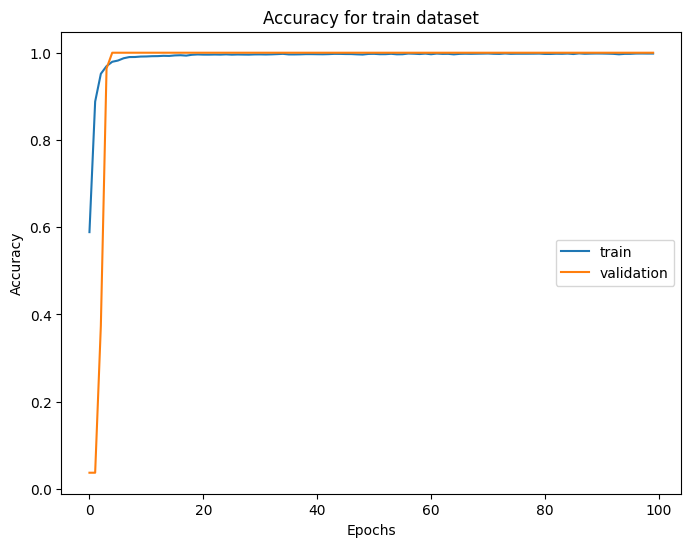

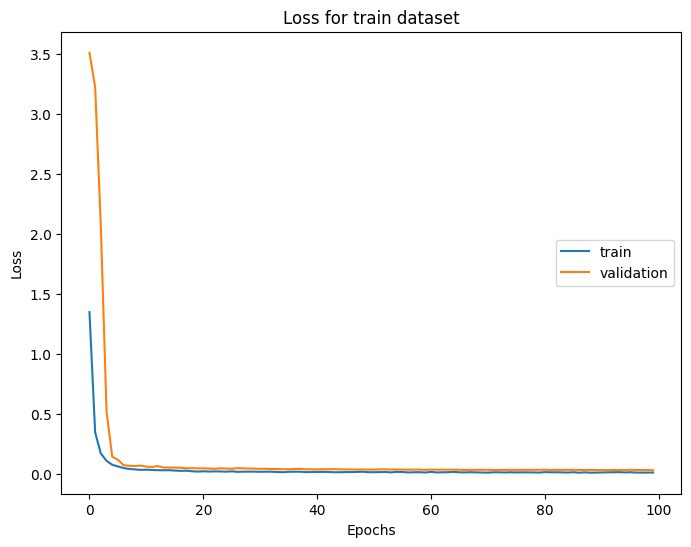

In [10]:
plotHistory(history= history, train= 'accuracy', validation= 'val_accuracy')
plotHistory(history= history, train= 'loss', validation= 'val_loss')

In [11]:
# Evaluate test dataset
testScore = model.evaluate(X_test, testTargets, verbose= 1)
print(f"{model.metrics_names[0]} : {testScore[0]}\n{model.metrics_names[1]} : {testScore[1] * 100} %")

254/254 [==============================] - 2s 9ms/step - loss: 0.0287 - accuracy: 1.0000
loss : 0.028707485646009445
accuracy : 100.0 %


254/254 [==============================] - 2s 7ms/step
Classification report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       300
           1       1.00      1.00      1.00       300
           2       1.00      1.00      1.00       300
           3       1.00      1.00      1.00       300
           4       1.00      1.00      1.00       300
           5       1.00      1.00      1.00       300
           6       1.00      1.00      1.00       300
           7       1.00      1.00      1.00       300
           8       1.00      1.00      1.00       300
           9       1.00      1.00      1.00       300
          10       1.00      1.00      1.00       300
          11       1.00      1.00      1.00       300
          12       1.00      1.00      1.00       300
          13       1.00      1.00      1.00       300
          14       1.00      1.00      1.00       300
          15       1.00      1.00      1.00       300
  

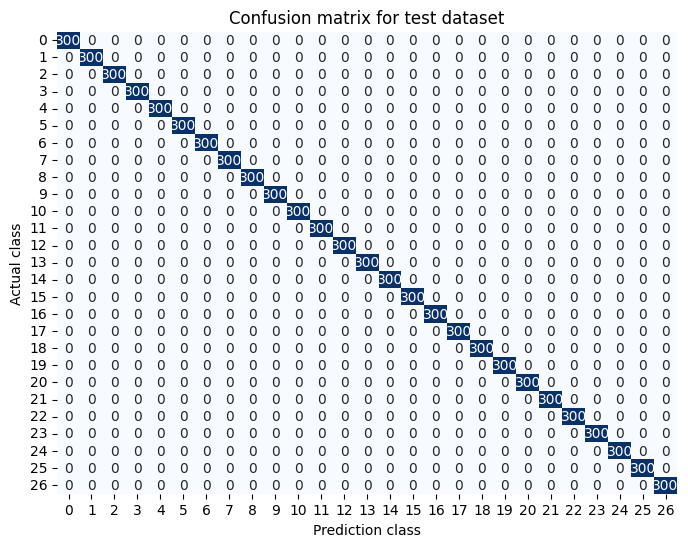

In [12]:
# Prediction for test dataset

prediction = model.predict(X_test)
predictionClass = np.argmax(prediction, axis= 1)        # One-hot encoding --> Original label

# Actual Class (One-hot encoding testTarget --> y_test)
if testTargets.ndim > 1:
    actualClass = np.argmax(testTargets, axis= 1)
else:
    actualClass = testTargets

# Classification report
print(f"Classification report: \n{classification_report(actualClass, predictionClass)}")

# Confusion matrix
plt.figure(figsize= (8, 6))
sns.heatmap(confusion_matrix(actualClass, predictionClass), 
            annot= True, 
            fmt= "d", 
            cmap= "Blues",
            cbar= False)
plt.title("Confusion matrix for test dataset")
plt.xlabel("Prediction class")
plt.ylabel("Actual class")
plt.show()

In [18]:
# Prediction for 1 image

randomImgIdx = random.randrange(0, X_test.shape[0])

predictStartTime = time.time()

predictionImg = X_test[randomImgIdx]
predictionImg = np.expand_dims(predictionImg, axis= 0)

testPrediction = model.predict(predictionImg)

predictEndTime = time.time()

print("Random image index: ", randomImgIdx)
print("Random actual label: ", i_test[randomImgIdx])
print("Random actual class: ", actualClass[randomImgIdx])
print("Random prediction class: ", predictionClass[randomImgIdx])

1/1 [==============================] - 0s 34ms/step
Random image index:  7672
Random actual label:  C9_448
Random actual class:  9
Random prediction class:  9
